# **built the training data with features from the feature store, enabled materialization to offline feature store, and performed a backfill**

# SDK Track - For Pure Python based development and Deployment

for training and inference operations in a production environment, we recommend that you materialize the features, for greater reliability and availability.

# **1. Preparing the notebook environment**

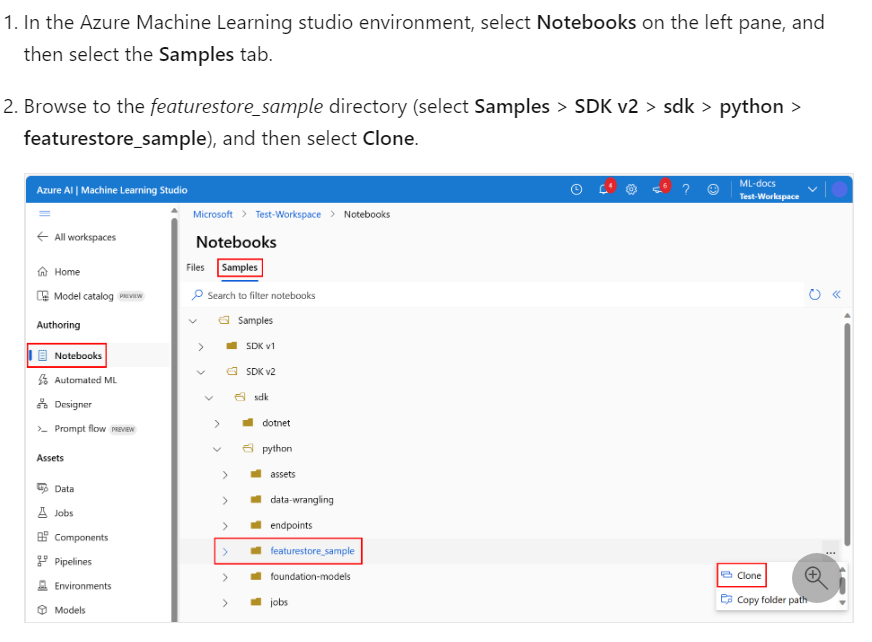

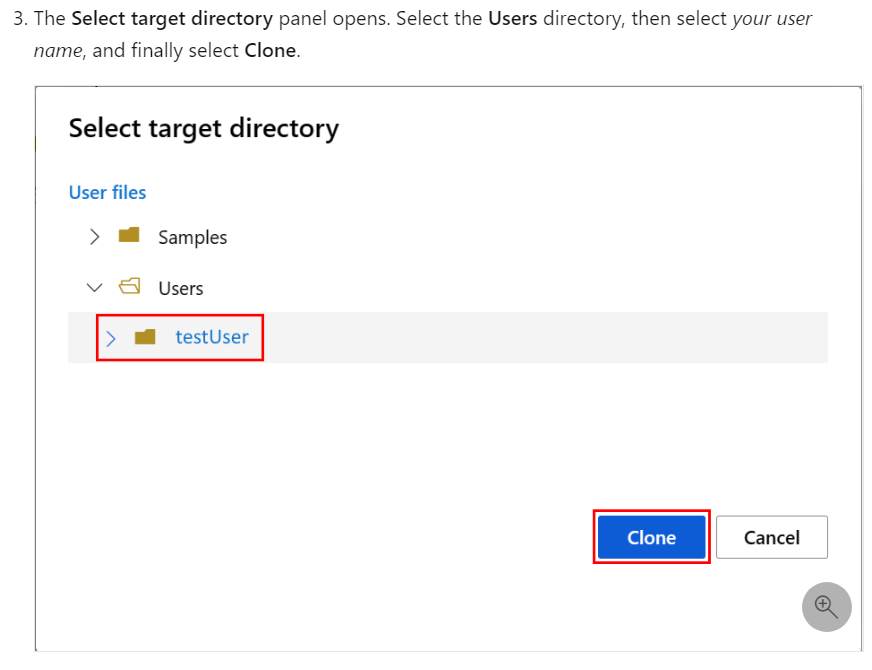

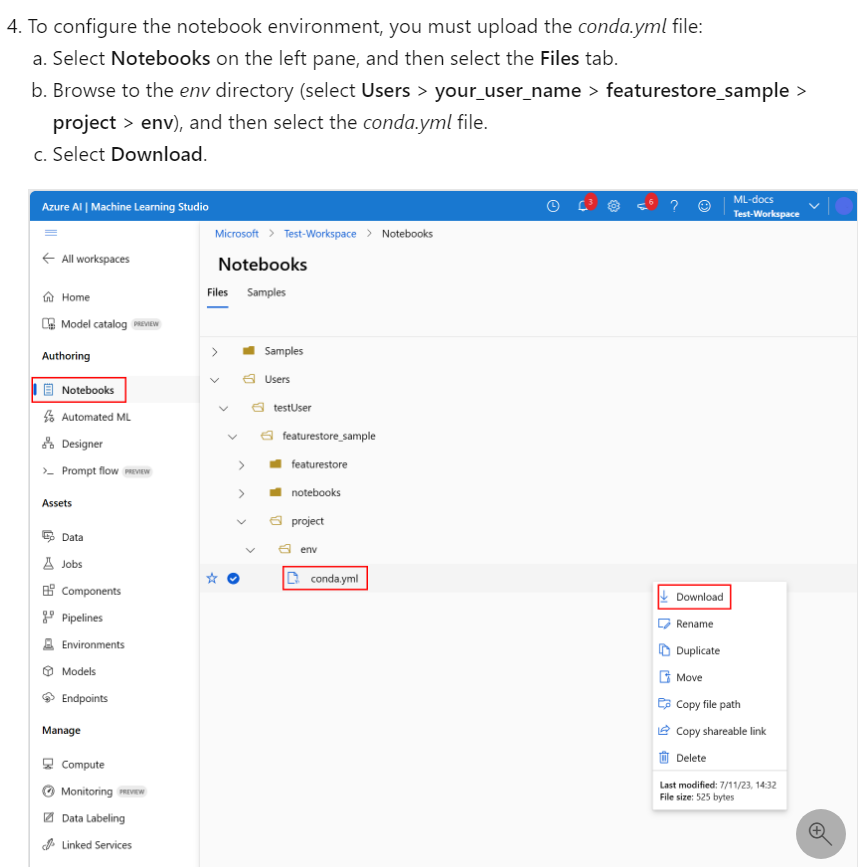

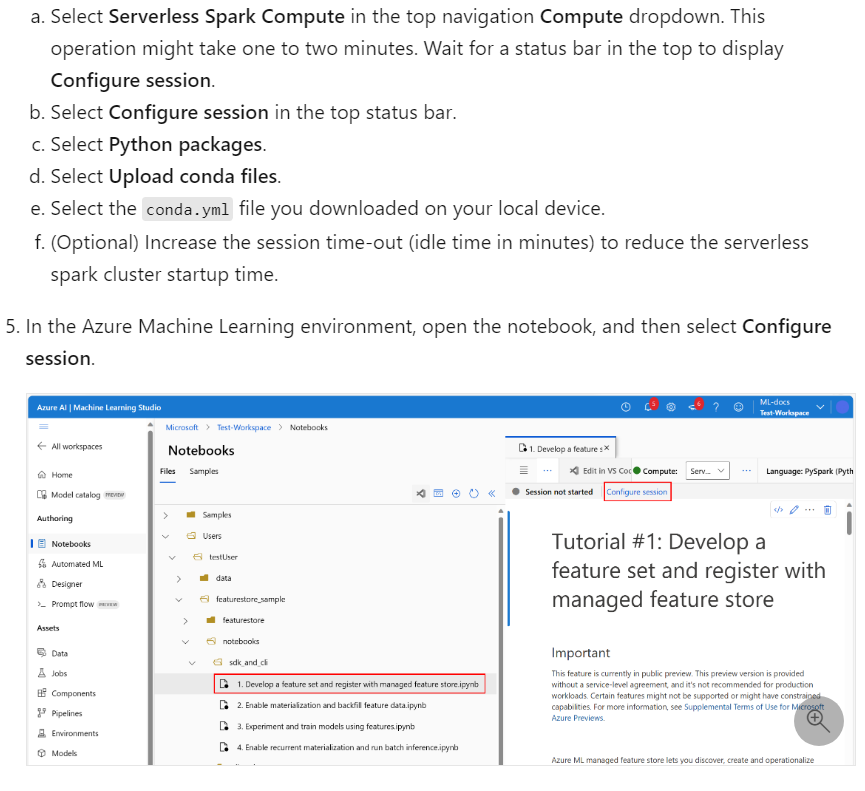

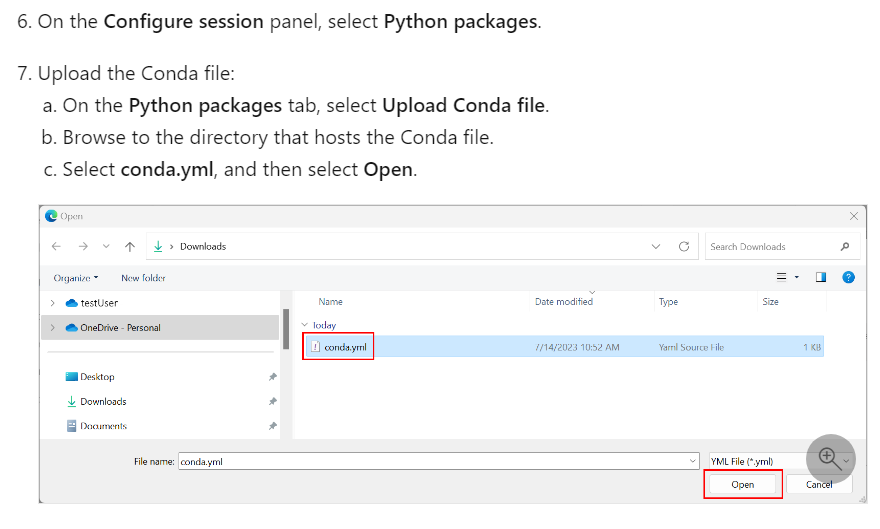

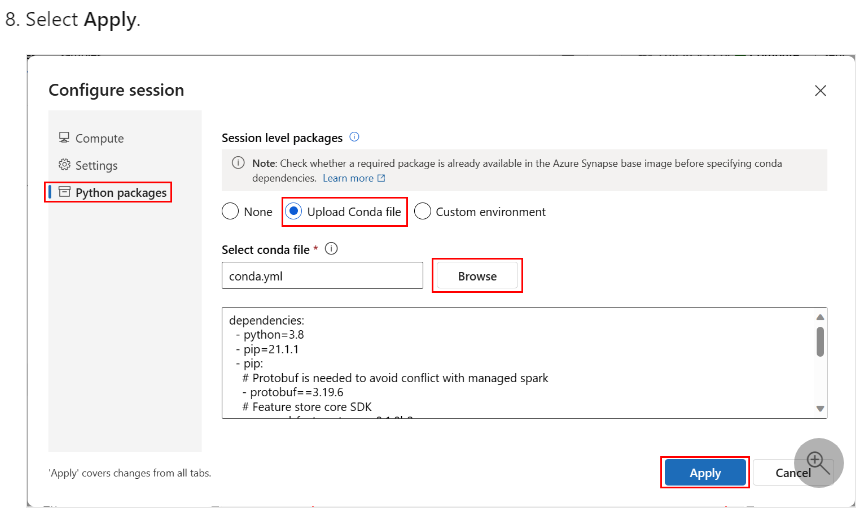

.

# **Start the Spark Session:**

In [ ]:
# Run this cell to start the spark session (any code block will start the session ). This can take around 10 mins.
print("start spark session")

# **Set up the root directory for the samples:**

setting up the root directory for samples is essential for maintaining organization, facilitating collaboration, ensuring clarity and consistency, supporting version control, aiding in testing and debugging, and preparing for deployment while developing and registering a feature set with a managed feature store.

In [ ]:
import os

# Please update <your_user_alias> below (or any custom directory you uploaded the samples to).
# You can find the name from the directory structure in the left navigation panel.
root_dir = "./Users/<your_user_alias>/featurestore_sample"

if os.path.isdir(root_dir):
    print("The folder exists.")
else:
    print("The folder does not exist. Please create or fix the path")

# **Set UP the CLI**

**Note:**

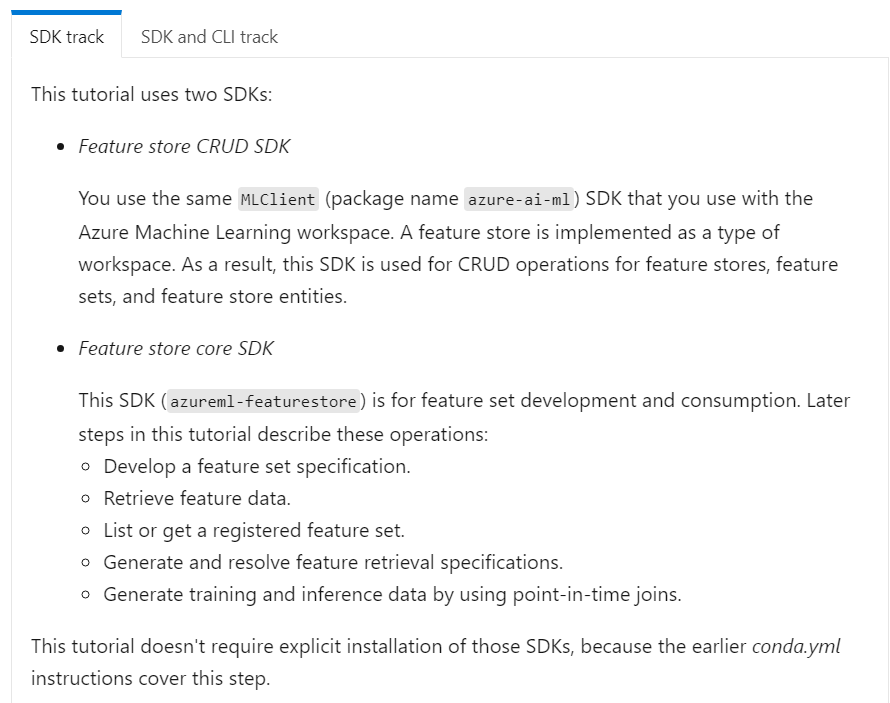

# **Create a minimal feature store:**

**1. Set feature store parameters, including name, location, and other values.**

In [ ]:
# We use the subscription, resource group, region of this active project workspace.
# You can optionally replace them to create the resources in a different subsciprtion/resource group, or use existing resources.
import os

featurestore_name = "<FEATURESTORE_NAME>"
featurestore_location = "eastus"
featurestore_subscription_id = os.environ["AZUREML_ARM_SUBSCRIPTION"]
featurestore_resource_group_name = os.environ["AZUREML_ARM_RESOURCEGROUP"]

**2. Create the feature store.**

In [ ]:
from azure.ai.ml import MLClient
from azure.ai.ml.entities import (
    FeatureStore,
    FeatureStoreEntity,
    FeatureSet,
)
from azure.ai.ml.identity import AzureMLOnBehalfOfCredential

ml_client = MLClient(
    AzureMLOnBehalfOfCredential(),
    subscription_id=featurestore_subscription_id,
    resource_group_name=featurestore_resource_group_name,
)


fs = FeatureStore(name=featurestore_name, location=featurestore_location)
# wait for feature store creation
fs_poller = ml_client.feature_stores.begin_create(fs)
print(fs_poller.result())

**3. Initialize a feature store core SDK client for Azure Machine Learning.**

As explained earlier in this tutorial, the feature store core SDK client is used to develop and consume features.

In [ ]:
# feature store client
from azureml.featurestore import FeatureStoreClient
from azure.ai.ml.identity import AzureMLOnBehalfOfCredential

featurestore = FeatureStoreClient(
    credential=AzureMLOnBehalfOfCredential(),
    subscription_id=featurestore_subscription_id,
    resource_group_name=featurestore_resource_group_name,
    name=featurestore_name,
)

4.Grant the "Azure Machine Learning Data Scientist" role on the feature store to your user identity. Obtain your Microsoft Entra object ID value from the Azure portal, as described in Find the user object ID.

https://learn.microsoft.com/en-us/partner-center/find-ids-and-domain-names#find-the-user-object-id



Assign the AzureML Data Scientist role to your user identity, so that it can create resources in feature store workspace. The permissions might need some time to propagate.

In [ ]:
your_aad_objectid = "<USER_AAD_OBJECTID>"

!az role assignment create --role "AzureML Data Scientist" --assignee-object-id $your_aad_objectid --assignee-principal-type User --scope $feature_store_arm_id

.

# **Prototype and develop a feature set:**

In these steps, you build a feature set named transactions that has rolling window aggregate-based features:

**1. Explore the transactions source data.**

This notebook uses sample data hosted in a publicly accessible blob container. It can be read into Spark only through a wasbs driver. When you create feature sets by using your own source data, host them in an Azure Data Lake Storage Gen2 account, and use an abfss driver in the data path.

In [ ]:
# remove the "." in the roor directory path as we need to generate absolute path to read from spark
transactions_source_data_path = "wasbs://data@azuremlexampledata.blob.core.windows.net/feature-store-prp/datasources/transactions-source/*.parquet"
transactions_src_df = spark.read.parquet(transactions_source_data_path)

display(transactions_src_df.head(5))
# Note: display(training_df.head(5)) displays the timestamp column in a different format. You can can call transactions_src_df.show() to see correctly formatted value

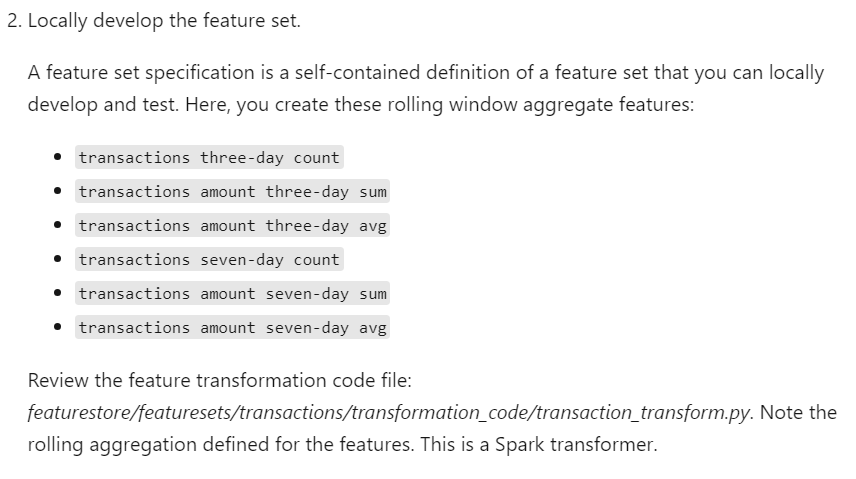

In [ ]:
from azureml.featurestore import create_feature_set_spec
from azureml.featurestore.contracts import (
    DateTimeOffset,
    TransformationCode,
    Column,
    ColumnType,
    SourceType,
    TimestampColumn,
)
from azureml.featurestore.feature_source import ParquetFeatureSource

transactions_featureset_code_path = (
    root_dir + "/featurestore/featuresets/transactions/transformation_code"
)

transactions_featureset_spec = create_feature_set_spec(
    source=ParquetFeatureSource(
        path="wasbs://data@azuremlexampledata.blob.core.windows.net/feature-store-prp/datasources/transactions-source/*.parquet",
        timestamp_column=TimestampColumn(name="timestamp"),
        source_delay=DateTimeOffset(days=0, hours=0, minutes=20),
    ),
    feature_transformation=TransformationCode(
        path=transactions_featureset_code_path,
        transformer_class="transaction_transform.TransactionFeatureTransformer",
    ),
    index_columns=[Column(name="accountID", type=ColumnType.string)],
    source_lookback=DateTimeOffset(days=7, hours=0, minutes=0),
    temporal_join_lookback=DateTimeOffset(days=1, hours=0, minutes=0),
    infer_schema=True,
)

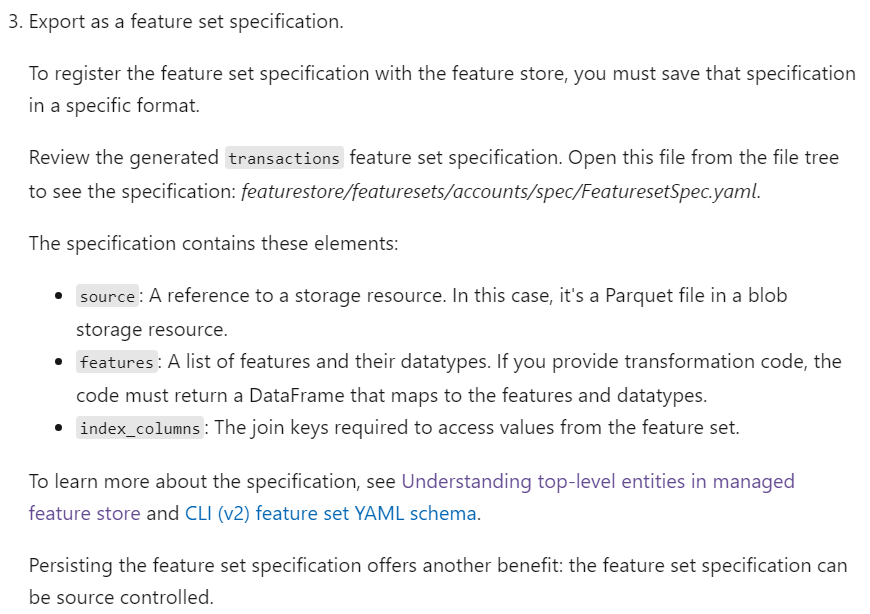

In [ ]:
import os

# Create a new folder to dump the feature set specification.
transactions_featureset_spec_folder = (
    root_dir + "/featurestore/featuresets/transactions/spec"
)

# Check if the folder exists, create one if it does not exist.
if not os.path.exists(transactions_featureset_spec_folder):
    os.makedirs(transactions_featureset_spec_folder)

transactions_featureset_spec.dump(transactions_featureset_spec_folder, overwrite=True)

# Register a feature store entity:

As a best practice, entities help enforce use of the same join key definition across feature sets that use the same logical entities. Examples of entities include accounts and customers. Entities are typically created once and then reused across feature sets.

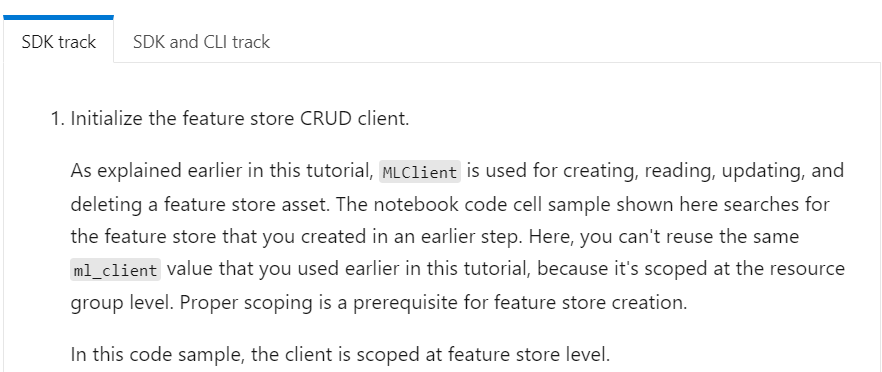

In [ ]:
# MLClient for feature store.
fs_client = MLClient(
    AzureMLOnBehalfOfCredential(),
    featurestore_subscription_id,
    featurestore_resource_group_name,
    featurestore_name,
)

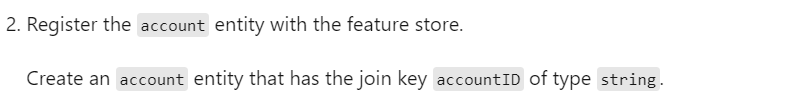

In [ ]:
from azure.ai.ml.entities import DataColumn, DataColumnType

account_entity_config = FeatureStoreEntity(
    name="account",
    version="1",
    index_columns=[DataColumn(name="accountID", type=DataColumnType.STRING)],
    stage="Development",
    description="This entity represents user account index key accountID.",
    tags={"data_typ": "nonPII"},
)

poller = fs_client.feature_store_entities.begin_create_or_update(account_entity_config)
print(poller.result())

.

# **Register the transaction feature set with the feature store:**

Transaction is just name of the feature set it could be any feature set.

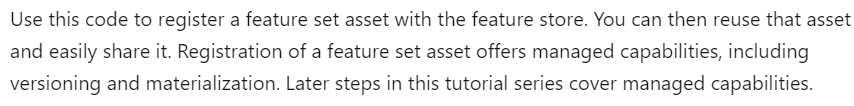

In [ ]:
from azure.ai.ml.entities import FeatureSetSpecification

transaction_fset_config = FeatureSet(
    name="transactions",
    version="1",
    description="7-day and 3-day rolling aggregation of transactions featureset",
    entities=[f"azureml:account:1"],
    stage="Development",
    specification=FeatureSetSpecification(path=transactions_featureset_spec_folder),
    tags={"data_type": "nonPII"},
)

poller = fs_client.feature_sets.begin_create_or_update(transaction_fset_config)
print(poller.result())

.

# **Explore the feature store UI**

https://ml.azure.com/home

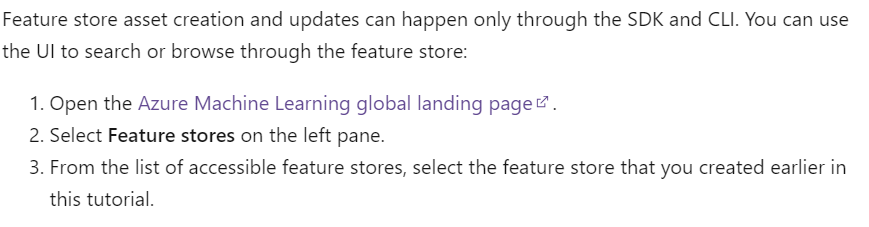

.

# **Grant the Storage Blob Data Reader role access to your user account in the offline store**

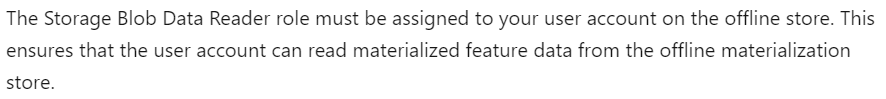

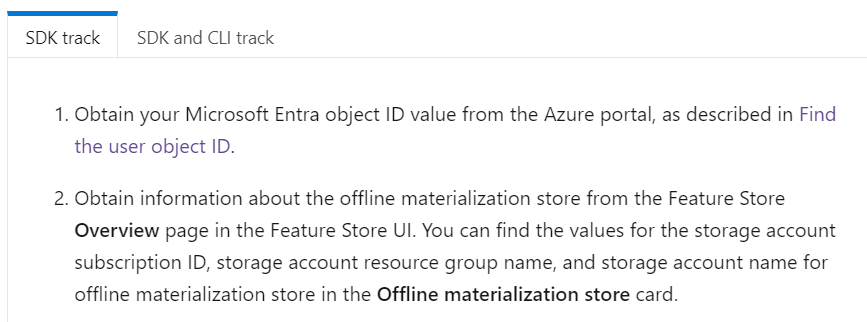

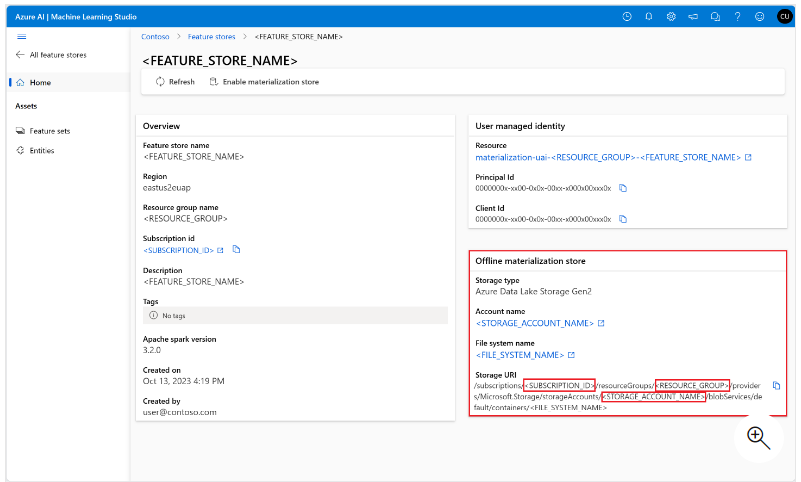

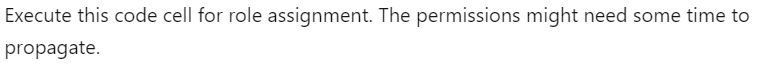

In [ ]:
# This utility function is created for ease of use in the docs tutorials. It uses standard azure API's.
# You can optionally inspect it `featurestore/setup/setup_storage_uai.py`.
import sys

sys.path.insert(0, root_dir + "/featurestore/setup")
from setup_storage_uai import grant_user_aad_storage_data_reader_role

your_aad_objectid = "<USER_AAD_OBJECTID>"
storage_subscription_id = "<SUBSCRIPTION_ID>"
storage_resource_group_name = "<RESOURCE_GROUP>"
storage_account_name = "<STORAGE_ACCOUNT_NAME>"

grant_user_aad_storage_data_reader_role(
    AzureMLOnBehalfOfCredential(),
    your_aad_objectid,
    storage_subscription_id,
    storage_resource_group_name,
    storage_account_name,
)

.

# **Generate a training data DataFrame by using the registered feature set**

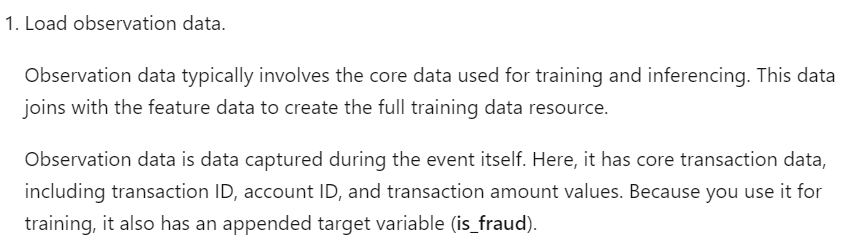

In [ ]:
observation_data_path = "wasbs://data@azuremlexampledata.blob.core.windows.net/feature-store-prp/observation_data/train/*.parquet"
observation_data_df = spark.read.parquet(observation_data_path)
obs_data_timestamp_column = "timestamp"

display(observation_data_df)
# Note: the timestamp column is displayed in a different format. Optionally, you can can call training_df.show() to see correctly formatted value

2. Get the registered feature set, and list its features.

In [ ]:
# Look up the featureset by providing a name and a version.
transactions_featureset = featurestore.feature_sets.get("transactions", "1")
# List its features.
transactions_featureset.features

In [ ]:
# Print sample values.
display(transactions_featureset.to_spark_dataframe().head(5))

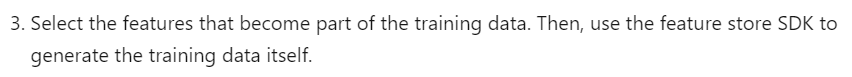

In [ ]:
from azureml.featurestore import get_offline_features

# You can select features in pythonic way.
features = [
    transactions_featureset.get_feature("transaction_amount_7d_sum"),
    transactions_featureset.get_feature("transaction_amount_7d_avg"),
]

# You can also specify features in string form: featureset:version:feature.
more_features = [
    f"transactions:1:transaction_3d_count",
    f"transactions:1:transaction_amount_3d_avg",
]

more_features = featurestore.resolve_feature_uri(more_features)
features.extend(more_features)

# Generate training dataframe by using feature data and observation data.
training_df = get_offline_features(
    features=features,
    observation_data=observation_data_df,
    timestamp_column=obs_data_timestamp_column,
)

# Ignore the message that says feature set is not materialized (materialization is optional). We will enable materialization in the subsequent part of the tutorial.
display(training_df)
# Note: the timestamp column is displayed in a different format. Optionally, you can can call training_df.show() to see correctly formatted value

.

# **Enable offline materialization on the transactions feature set**

After feature set materialization is enabled, you can perform a backfill.

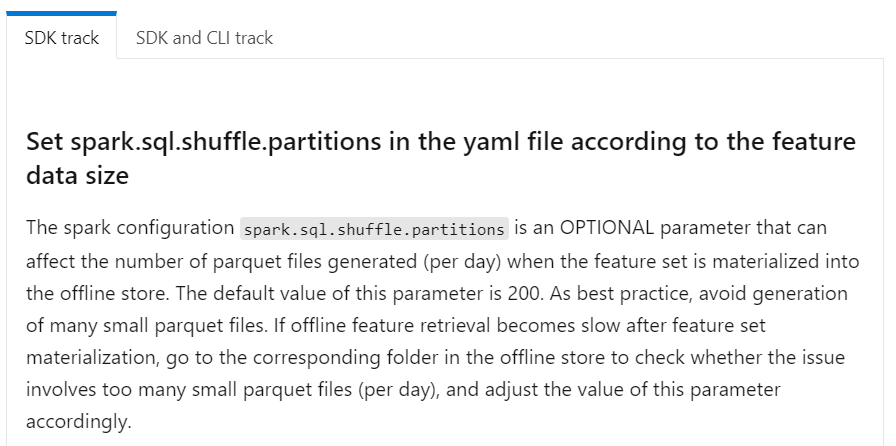

In [ ]:
from azure.ai.ml.entities import (
    MaterializationSettings,
    MaterializationComputeResource,
)

transactions_fset_config = fs_client._featuresets.get(name="transactions", version="1")

transactions_fset_config.materialization_settings = MaterializationSettings(
    offline_enabled=True,
    resource=MaterializationComputeResource(instance_type="standard_e8s_v3"),
    spark_configuration={
        "spark.driver.cores": 4,
        "spark.driver.memory": "36g",
        "spark.executor.cores": 4,
        "spark.executor.memory": "36g",
        "spark.executor.instances": 2,
        "spark.sql.shuffle.partitions": 1,
    },
    schedule=None,
)

fs_poller = fs_client.feature_sets.begin_create_or_update(transactions_fset_config)
print(fs_poller.result())

You can also save the feature set asset as a YAML resource.

In [ ]:
## uncomment to run
transactions_fset_config.dump(
    root_dir
    + "/featurestore/featuresets/transactions/featureset_asset_offline_enabled.yaml"
)

.

# **Backfill data for the transactions feature set**

As explained earlier, materialization computes the feature values for a feature window, and it stores these computed values in a materialization store. Feature materialization increases the reliability and availability of the computed values. All feature queries now use the values from the materialization store. This step performs a one-time backfill for a feature window of 18 months.

This code cell materializes data by current status None or Incomplete for the defined feature window.

In [ ]:
from datetime import datetime
from azure.ai.ml.entities import DataAvailabilityStatus

st = datetime(2022, 1, 1, 0, 0, 0, 0)
et = datetime(2023, 6, 30, 0, 0, 0, 0)

poller = fs_client.feature_sets.begin_backfill(
    name="transactions",
    version="1",
    feature_window_start_time=st,
    feature_window_end_time=et,
    data_status=[DataAvailabilityStatus.NONE],
)
print(poller.result().job_ids)

In [ ]:
# Get the job URL, and stream the job logs.
fs_client.jobs.stream(poller.result().job_ids[0])

Print sample data from the feature set. The output information shows that the data was retrieved from the materialization store. The get_offline_features() method retrieved the training and inference data. It also uses the materialization store by default.

In [ ]:
# Look up the feature set by providing a name and a version and display few records.
transactions_featureset = featurestore.feature_sets.get("transactions", "1")
display(transactions_featureset.to_spark_dataframe().head(5))

# **Further exploring offline feature materialization**

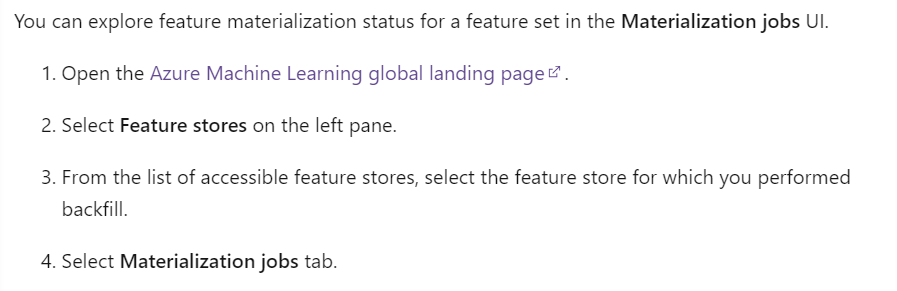

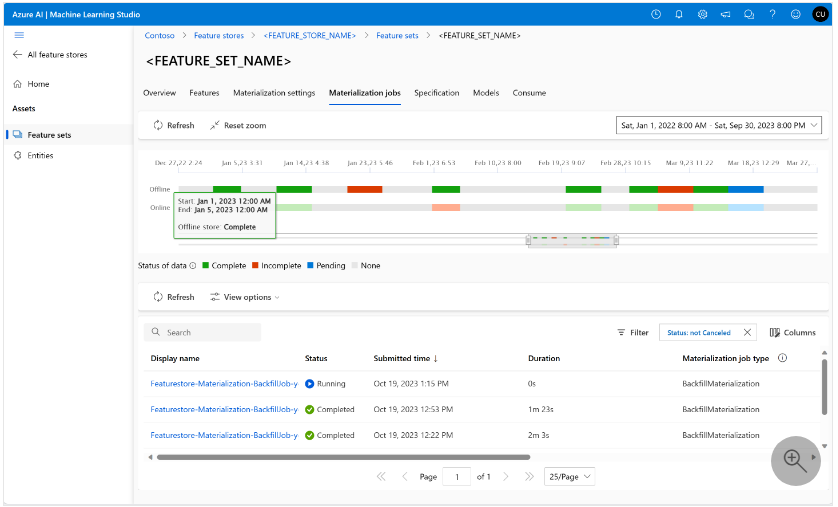

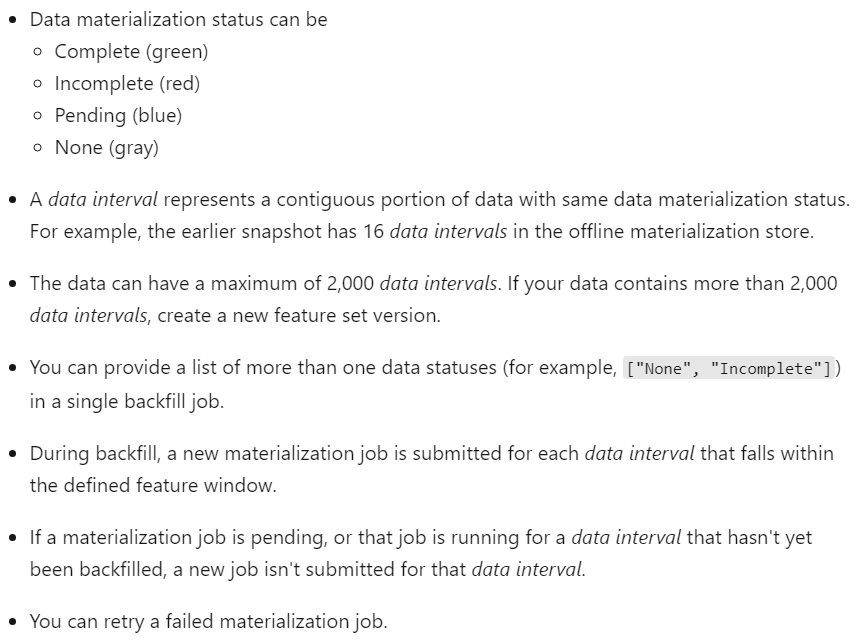

In [ ]:
poller = fs_client.feature_sets.begin_backfill(
    name="transactions",
    version=version,
    job_id="<JOB_ID_OF_FAILED_MATERIALIZATION_JOB>",
)
print(poller.result().job_ids)

# **Updating offline materialization store**

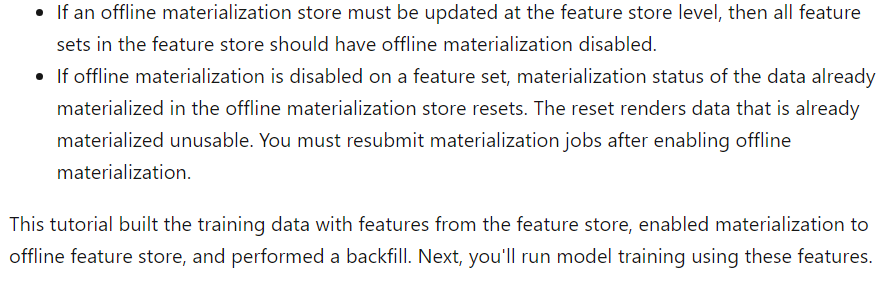